Intrusion Detection System based on Random Forest


importing Libraries

In [78]:
# importing required libraries
import numpy as np
import pandas as pd 
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.ensemble import RandomForestClassifier

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

import keras
from keras.applications import VGG16
from keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
# representation of model layers

In [79]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

Importing Dataset

In [80]:
train_data = pd.read_csv("Dataset/KDDTrain+.txt", names=feature)
test_data=pd.read_csv("Dataset/KDDTest+.txt", names=feature)
test_data21=pd.read_csv("Dataset/KDDTest-21.txt", names=feature)
data=pd.concat([train_data,test_data],ignore_index=True)

In [81]:
data.drop(["difficulty"],axis=1,inplace=True)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

In [83]:
data['label'].value_counts()

label
normal             77054
neptune            45871
satan               4368
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
loadmodule            11
ftp_write             11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm           

Changing Labels

In [84]:
def label_change(df):
    df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.label.replace(['ftp_write','guess_passwd','imap','multihop','phf','spy','warezclient','warezmaster','snmpgetattack','httptunnel','snmpguess','sendmail','named','xlock','xsnoop'],'R2L',inplace=True)
    df.label.replace(['ipsweep','nmap','portsweep','satan','mscan','saint'],'Probe',inplace=True)
    df.label.replace(['buffer_overflow','loadmodule','perl','rootkit','ps','xterm','sqlattack'],'U2R',inplace=True)

In [85]:
label_change(data)

/tmp/ipykernel_2308/2759453117.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)


In [86]:
data.label.value_counts()

label
normal    77054
Dos       53387
Probe     14077
R2L        3880
U2R         119
Name: count, dtype: int64

Dataframe

In [87]:
label = pd.DataFrame(data.label)

In [88]:
scaler=StandardScaler();
def standardization(data,col):
    for i in col:
        arr=data[i]
        arr=np.array(arr)
        data[i]=scaler.fit_transform(arr.reshape(len(arr),1))
    return data
numeric_col=data.select_dtypes(include='number').columns
data=standardization(data,numeric_col)

In [89]:
le=preprocessing.LabelEncoder()
encode=label.apply(le.fit_transform)
data['intrusion']=encode


In [90]:
data.drop(['label'],axis=1,inplace=True)

In [91]:
data=pd.get_dummies(data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")
print(data.shape)

(148517, 123)


In [92]:
y_data=data['intrusion']
X_data=data.drop(labels=['intrusion'],axis=1)

print('X_train has shape:',X_data.shape,'\nY_train has shape:',y_data.shape)

X_train has shape: (148517, 122) 
Y_train has shape: (148517,)


In [93]:
lb=LabelBinarizer()
lb.fit(y_data)
X_data=np.array(X_data)
y_data=np.array(y_data)


In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print(X_train.shape,'\n',X_test.shape)

(118813, 122) 
 (29704, 122)


In [95]:
model=RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(X_train,Y_train)

RandomForestClassifier(random_state=42)

In [96]:
Y_pred=model.predict(X_test)
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10688
           1       0.99      1.00      0.99      2749
           2       0.97      0.91      0.94       792
           3       0.91      0.40      0.56        25
           4       0.99      1.00      1.00     15450

    accuracy                           0.99     29704
   macro avg       0.97      0.86      0.90     29704
weighted avg       0.99      0.99      0.99     29704



In [97]:
print('Accuracy:',accuracy_score(Y_test,Y_pred))

Accuracy: 0.9949501750605979


In [99]:
Y_test = Y_test.reshape(-1, 1)
Y_pred = Y_pred.reshape(-1, 1)

In [100]:
Y_test_org=lb.inverse_transform(Y_test)
Y_pred_org=lb.inverse_transform(Y_pred)
cm=confusion_matrix(Y_test_org,Y_pred_org)
print(cm)

[[29704]]


/var/data/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


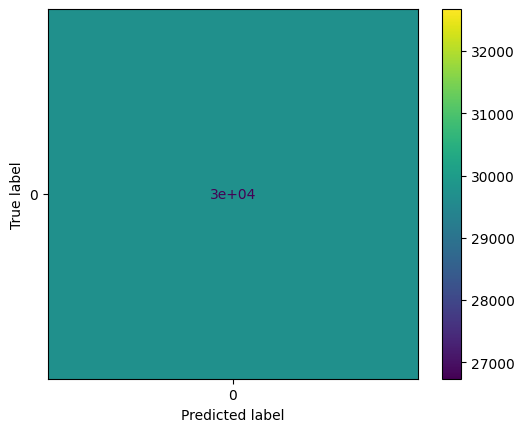

In [101]:
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()

In [104]:
train_acc = model.score(X_train, Y_train)
test_acc = accuracy_score(Y_test, Y_pred)

In [105]:
print('Training Accuracy:', train_acc)
print('Testing Accuracy:', test_acc)

Training Accuracy: 0.9994276720560882
Testing Accuracy: 0.9949501750605979


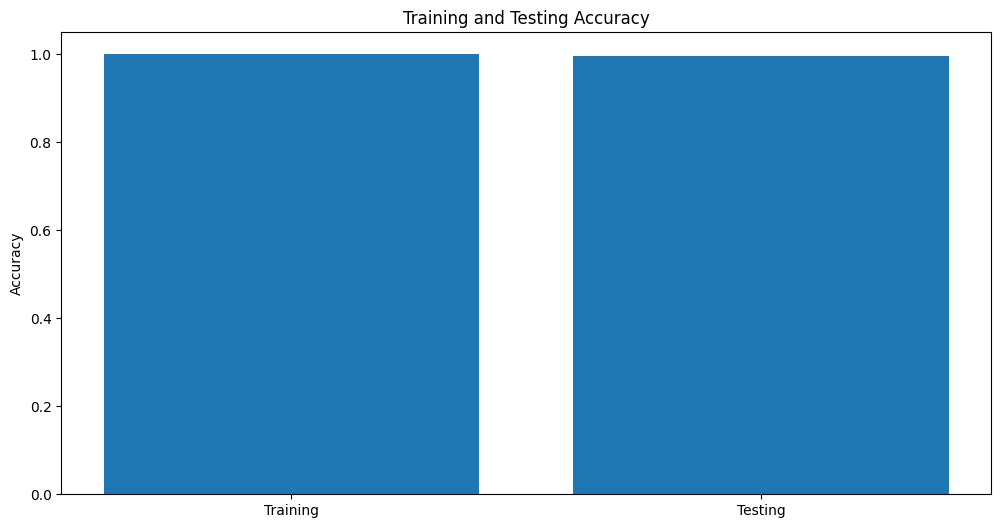

In [106]:
plt.figure(figsize=(12, 6))
plt.bar(['Training', 'Testing'], [train_acc, test_acc])
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.show()